# 1. Parzen windows density estimates are given by $\hat{p}(x)=\frac{1}{n}\sum_ik(x,x_i)$. Prove that for binary classification the function $\hat{p}(x,y=1)-\hat{p}(x,y=-1)$, as obtained by Parzen windows is equivalent to Nadaraya–Watson classification.

The equation of Nadaraya–Watson classification is:
$$f(q)=\sum_iv_i\frac{\alpha(q,k_i)}{\sum_j\alpha(q,k_i)}$$
As the label of binary classification is ${1,-1}$, so the equation can be modified as:
$$f(q)=\sum^{y=1}\hat{p}(x)-\sum^{y=-1}\hat{p}(x)=\hat{p}(x,y=1)-\hat{p}(x,y=-1)$$

# 2. Implement stochastic gradient descent to learn a good value for kernel widths in Nadaraya–Watson regression.

In [22]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

# Define some kernels
def gaussian(x, sigma):
    return torch.exp(-x**2 / 2/torch.pow(sigma,2))

def boxcar(x):
    return torch.abs(x) < 1.0

def constant(x):
    return 1.0 + 0 * x

def epanechikov(x):
    return torch.max(1 - torch.abs(x), torch.zeros_like(x))



class SyntheticNWData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""

    def __init__(self, noise=0.01, num_train=1000, num_val=1000,
                 batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = torch.randn(n, 1)
        noise = torch.randn(n, 1) * noise
        self.y = 2 * torch.sin(self.X) + self.X + noise

    def get_tensorloader(self, tensor, train, indices=slice(0, None)):
        tensor = tuple(a[indices] for a in tensor)
        dataset = torch.utils.data.TensorDataset(*tensor)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

    def get_dataloader(self, train):
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    
class NWReg(d2l.Module):
    def __init__(self, x_train, y_train, kernel, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (1, 1), requires_grad=True)
        
    def forward(self, X):
        y_hat, attention_w = self.nadaraya_watson(self.x_train, self.y_train, X, self.kernel)
        return y_hat
    
    def loss(self, y_hat, y):
        l = (y_hat - y)**2 / 2
        return l.mean()
    
    def configure_optimizers(self):
        return d2l.SGD([self.w], self.lr)
    
    def nadaraya_watson(x_train, y_train, x_val, kernel):
        dists = x_train.reshape((-1, 1)) - x_val.reshape((1, -1))
        # print(x_train.shape,x_val.shape,dists.shape)
        # Each column/row corresponds to each query/key
        k = kernel(dists).type(torch.float32)
        # Normalization over keys for each query
        attention_w = k / k.sum(0)
        y_hat = y_train@attention_w.T
        return y_hat, attention_w

In [23]:
data = SyntheticNWData(batch_size=1)
model = NWReg(x_train=data.X[:data.num_train], y_train=data.y[:data.num_train], kernel=gaussian, lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
trainer.fit(model, data)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

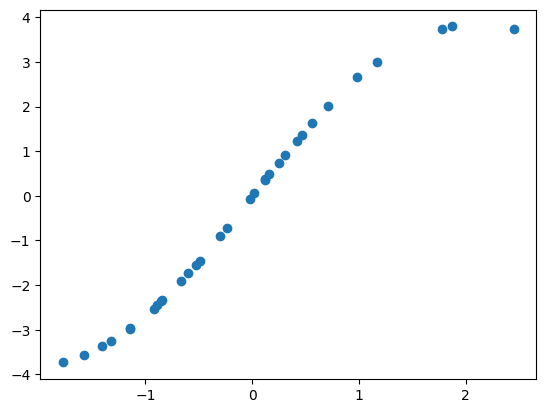

In [10]:
import matplotlib.pyplot as plt
data = SyntheticNWData()
X,y = next(iter(data.get_dataloader(True)))

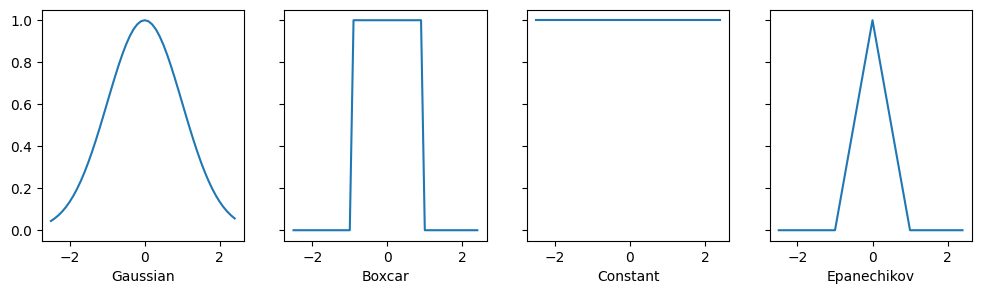

In [4]:

fig, axes = d2l.plt.subplots(1, 4, sharey=True, figsize=(12, 3))

kernels = (gaussian, boxcar, constant, epanechikov)
names = ('Gaussian', 'Boxcar', 'Constant', 'Epanechikov')
x = torch.arange(-2.5, 2.5, 0.1)
for kernel, name, ax in zip(kernels, names, axes):
    ax.plot(x.detach().numpy(), kernel(x).detach().numpy())
    ax.set_xlabel(name)

d2l.plt.show()

## 2.1 What happens if you just use the above estimates to minimize $(f(x_i)-y_i)^2$ directly? Hint: $y_i$ is part of the terms used to compute $f$.

## 2.2 Remove $(x_i,y_i)$ from the estimate for $f(x)$ and optimize over the kernel widths. Do you still observe overfitting?

# 3. Assume that all $x$ lie on the unit sphere, i.e., all satisfy $\left\|x\right\|=1$. Can you simplify the $\left\|x-x_i\right\|^2$ term in the exponential? Hint: we will later see that this is very closely related to dot product attention.

# 4. Recall that Mack and Silverman (1982) proved that Nadaraya–Watson estimation is consistent. How quickly should you reduce the scale for the attention mechanism as you get more data? Provide some intuition for your answer. Does it depend on the dimensionality of the data? How?